# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.800678  1.345949  0.0  0.126989  0.333821  0.916389  2  2  13.242172   
1 -0.505554  2.366413  0.0  0.523357 -2.077019 -0.936336  3  0  13.753946   
2  0.412457  0.503684  0.0  0.939464 -0.922193  0.521822  1  3  14.781595   
3 -0.101186  1.077743  0.0  0.553270 -2.203040 -0.291405  2  2  11.227239   
4 -0.529285 -0.504391  1.0  0.449629 -0.697495 -1.408552  3  2  25.140066   

            y  
0  191.303984  
1  221.169681  
2  182.315574  
3  151.508584  
4  231.174732  
True causal estimate is 11.314300590771746


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

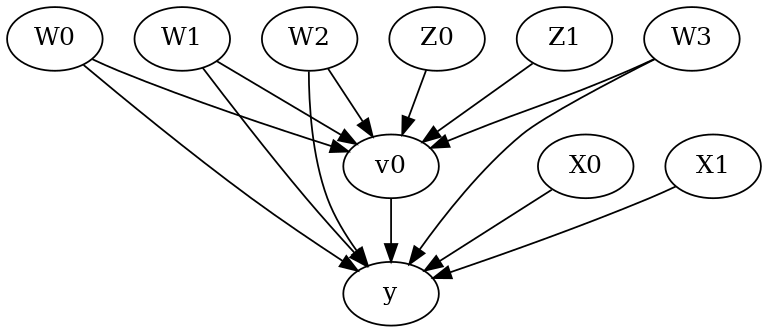

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W2,U) = P(y|v0,W3,W1,W0,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W2,U) = P(y|v0,W3,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W1+W0+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 11.314529639803853
### Conditional Estimates
__categorical__X1  __categorical__X0           
(-3.331, -0.214]   (-5.228000000000001, -1.449]     7.404406
                   (-1.449, -0.86]                  7.728834
                   (-0.86, -0.354]                  7.851294
                   (-0.354, 0.209]                  8.090135
                   (0.209, 3.226]                   8.431108
(-0.214, 0.368]    (-5.228000000000001, -1.449]     9.468733
                   (-1.449, -0.86]                  9.813081
                   (-0.86, -0.354]                 10.01676

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-09-06 07:57:01.917636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 07:57:01.917685: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W2,U) = P(y|v0,W3,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W1+W0+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 11.961722070951952
Effect estimates: [ 8.77044922 15.85893968 10.31936948 13.72219759 13.55334647 11.13603926
 11.41058164  7.01341036 11.95280493 11.50918309 12.48958679  9.67085953
  9.5365061  12.43964469 11.05738808 11.3858881  10.02888179  8.84935546
  9.90842072  8.96192686 15.51263827  9.57011107 13.88962227  9.96747285
 12.92325367 12.4355694  12.95363601  9.13829598 13.89666348 13.87339386
 14.55382556 10.66251513 14.84024699  7.90744676  5.74879003 11.32237887
 12.68188309 15.82444869 14.47326745 14.42867556  8.99257713 13.09990286
 11.5

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.314300590771746


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W2,U) = P(y|v0,W3,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W1+W0+W2 | X1,X0
Target units: 

## Estimate
Mean value: 11.246182663653345
Effect estimates: [12.95613294 15.60213893 11.3178175  ... 10.34488673 10.14400132
 10.28198961]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W2,U) = P(y|v0,W3,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W1+W0+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 11.233171472447651
Effect estimates: [12.95809152 15.64119827 11.33019179 ... 10.32055462 10.12884031
 10.27139274]
95.0% confidence interval: (array([12.93593381, 15.63044131, 11.29871565, ..., 10.28204094,
       10.09360556, 10.23861206]), array([13.14091279, 15.983054  , 11.47622048, ..., 10.3870214 ,
       10.21882619, 10.37012059]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[10.28483325 12.56914136 12.48781782 11.60174363 10.2103924  11.99441725
 10.15367156 10.86328687 12.17487348 11.91783376]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.764057  0.450272  0.0  0.656029  1.142141 -0.445147  0.745178   
1    -0.444052  0.109296  0.0  0.172879  1.888321 -0.257482  0.085540   
2     1.106045  0.735017  0.0  0.660409 -0.274255 -0.348785 -0.147476   
3     0.632463  2.094124  0.0  0.472479 -0.322808 -2.076200 -0.188830   
4     0.816860  2.572195  0.0  0.663069  0.228008  0.076311  0.708471   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.445802 -0.272080  0.0  0.287459  1.405392 -1.443365 -1.615208   
9996  1.902102  0.497548  0.0  0.640685 -0.636069 -1.377797 -1.401333   
9997  0.792584 -1.219595  1.0  0.683735  0.208132 -2.735570 -0.890241   
9998  0.888967  2.087203  0.0  0.479059  1.725960 -0.840303  0.067324   
9999 -0.456824  1.465901  0.0  0.233018 -0.873286 -0.931528 -0.535950   

            W3  v0  y  
0     0.173787   1  1  
1    -0.118060   1  1  
2    -0.952299   1  1  
3    -1.379754   0  0  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W1,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W2,U) = P(y|v0,W3,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W1+W0+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.8566071826995242
Effect estimates: [0.80877869 0.80055847 0.86515478 ... 0.7682778  0.92212161 0.86246066]

True causal estimate is 0.6141


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-09-06 07:59:55.561875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 07:59:55.561925: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 07:59:55.561949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b4c18262cd13): /proc/driver/nvidia/version does not exist
2022-09-06 07:59:55.562239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:25 - loss: 36.4597

 33/313 [==>...........................] - ETA: 0s - loss: 19.6828  

 66/313 [=====>........................] - ETA: 0s - loss: 12.1337

 98/313 [========>.....................] - ETA: 0s - loss: 9.4411 

129/313 [===========>..................] - ETA: 0s - loss: 8.0421

161/313 [==============>...............] - ETA: 0s - loss: 7.1144

192/313 [=================>............] - ETA: 0s - loss: 6.4820

223/313 [====================>.........] - ETA: 0s - loss: 6.0032

254/313 [=======================>......] - ETA: 0s - loss: 5.6263

285/313 [==========================>...] - ETA: 0s - loss: 5.3268

313/313 [==============================] - 1s 2ms/step - loss: 5.1022


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 2.7889

 33/313 [==>...........................] - ETA: 0s - loss: 2.7329

 64/313 [=====>........................] - ETA: 0s - loss: 2.7379

 95/313 [========>.....................] - ETA: 0s - loss: 2.7211

125/313 [==========>...................] - ETA: 0s - loss: 2.7141

156/313 [=============>................] - ETA: 0s - loss: 2.6992

187/313 [================>.............] - ETA: 0s - loss: 2.6873

219/313 [===================>..........] - ETA: 0s - loss: 2.6823

252/313 [=======================>......] - ETA: 0s - loss: 2.6725

284/313 [==========================>...] - ETA: 0s - loss: 2.6559

313/313 [==============================] - 1s 2ms/step - loss: 2.6421


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.4271

 32/313 [==>...........................] - ETA: 0s - loss: 2.5802

 63/313 [=====>........................] - ETA: 0s - loss: 2.5758

 95/313 [========>.....................] - ETA: 0s - loss: 2.5612

127/313 [===========>..................] - ETA: 0s - loss: 2.5524

159/313 [==============>...............] - ETA: 0s - loss: 2.5457

191/313 [=================>............] - ETA: 0s - loss: 2.5387

223/313 [====================>.........] - ETA: 0s - loss: 2.5366

256/313 [=======================>......] - ETA: 0s - loss: 2.5311

289/313 [==========================>...] - ETA: 0s - loss: 2.5254

313/313 [==============================] - 0s 2ms/step - loss: 2.5204


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.4886

 34/313 [==>...........................] - ETA: 0s - loss: 2.4941

 67/313 [=====>........................] - ETA: 0s - loss: 2.5131

100/313 [========>.....................] - ETA: 0s - loss: 2.5071

132/313 [===========>..................] - ETA: 0s - loss: 2.4848

164/313 [==============>...............] - ETA: 0s - loss: 2.4734

195/313 [=================>............] - ETA: 0s - loss: 2.4779

227/313 [====================>.........] - ETA: 0s - loss: 2.4758

260/313 [=======================>......] - ETA: 0s - loss: 2.4640

292/313 [==========================>...] - ETA: 0s - loss: 2.4656

313/313 [==============================] - 0s 2ms/step - loss: 2.4650


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.4886

 33/313 [==>...........................] - ETA: 0s - loss: 2.4027

 65/313 [=====>........................] - ETA: 0s - loss: 2.4239

 97/313 [========>.....................] - ETA: 0s - loss: 2.4310

127/313 [===========>..................] - ETA: 0s - loss: 2.4246

159/313 [==============>...............] - ETA: 0s - loss: 2.4193

191/313 [=================>............] - ETA: 0s - loss: 2.4220

223/313 [====================>.........] - ETA: 0s - loss: 2.4235

254/313 [=======================>......] - ETA: 0s - loss: 2.4253

285/313 [==========================>...] - ETA: 0s - loss: 2.4288

313/313 [==============================] - 1s 2ms/step - loss: 2.4270


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.3518

 34/313 [==>...........................] - ETA: 0s - loss: 2.4239

 66/313 [=====>........................] - ETA: 0s - loss: 2.4343

 99/313 [========>.....................] - ETA: 0s - loss: 2.4335

130/313 [===========>..................] - ETA: 0s - loss: 2.4213

162/313 [==============>...............] - ETA: 0s - loss: 2.4110

193/313 [=================>............] - ETA: 0s - loss: 2.4118

225/313 [====================>.........] - ETA: 0s - loss: 2.4072

256/313 [=======================>......] - ETA: 0s - loss: 2.4054

288/313 [==========================>...] - ETA: 0s - loss: 2.4066

313/313 [==============================] - 1s 2ms/step - loss: 2.4075


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.3475

 33/313 [==>...........................] - ETA: 0s - loss: 2.4094

 65/313 [=====>........................] - ETA: 0s - loss: 2.3913

 96/313 [========>.....................] - ETA: 0s - loss: 2.3940

128/313 [===========>..................] - ETA: 0s - loss: 2.3873

159/313 [==============>...............] - ETA: 0s - loss: 2.3834

190/313 [=================>............] - ETA: 0s - loss: 2.3871

221/313 [====================>.........] - ETA: 0s - loss: 2.3850

253/313 [=======================>......] - ETA: 0s - loss: 2.3841

283/313 [==========================>...] - ETA: 0s - loss: 2.3827

313/313 [==============================] - 1s 2ms/step - loss: 2.3794


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.2342

 34/313 [==>...........................] - ETA: 0s - loss: 2.3635

 65/313 [=====>........................] - ETA: 0s - loss: 2.3711

 96/313 [========>.....................] - ETA: 0s - loss: 2.3806

127/313 [===========>..................] - ETA: 0s - loss: 2.3846

158/313 [==============>...............] - ETA: 0s - loss: 2.3808

190/313 [=================>............] - ETA: 0s - loss: 2.3812

222/313 [====================>.........] - ETA: 0s - loss: 2.3804

253/313 [=======================>......] - ETA: 0s - loss: 2.3793

284/313 [==========================>...] - ETA: 0s - loss: 2.3740

313/313 [==============================] - 1s 2ms/step - loss: 2.3714


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.2490

 34/313 [==>...........................] - ETA: 0s - loss: 2.3424

 67/313 [=====>........................] - ETA: 0s - loss: 2.3710

 98/313 [========>.....................] - ETA: 0s - loss: 2.3722

130/313 [===========>..................] - ETA: 0s - loss: 2.3722

162/313 [==============>...............] - ETA: 0s - loss: 2.3686

193/313 [=================>............] - ETA: 0s - loss: 2.3640

224/313 [====================>.........] - ETA: 0s - loss: 2.3594

256/313 [=======================>......] - ETA: 0s - loss: 2.3580

288/313 [==========================>...] - ETA: 0s - loss: 2.3553

313/313 [==============================] - 1s 2ms/step - loss: 2.3533


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.3833

 34/313 [==>...........................] - ETA: 0s - loss: 2.3614

 65/313 [=====>........................] - ETA: 0s - loss: 2.3454

 95/313 [========>.....................] - ETA: 0s - loss: 2.3428

127/313 [===========>..................] - ETA: 0s - loss: 2.3476

159/313 [==============>...............] - ETA: 0s - loss: 2.3364

191/313 [=================>............] - ETA: 0s - loss: 2.3426

224/313 [====================>.........] - ETA: 0s - loss: 2.3426

257/313 [=======================>......] - ETA: 0s - loss: 2.3455

290/313 [==========================>...] - ETA: 0s - loss: 2.3448

313/313 [==============================] - 1s 2ms/step - loss: 2.3442


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.2465

 33/313 [==>...........................] - ETA: 0s - loss: 2.3469

 65/313 [=====>........................] - ETA: 0s - loss: 2.3477

 96/313 [========>.....................] - ETA: 0s - loss: 2.3448

127/313 [===========>..................] - ETA: 0s - loss: 2.3463

160/313 [==============>...............] - ETA: 0s - loss: 2.3454

192/313 [=================>............] - ETA: 0s - loss: 2.3438

223/313 [====================>.........] - ETA: 0s - loss: 2.3400

255/313 [=======================>......] - ETA: 0s - loss: 2.3396

287/313 [==========================>...] - ETA: 0s - loss: 2.3360

313/313 [==============================] - 1s 2ms/step - loss: 2.3392


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.5217

 33/313 [==>...........................] - ETA: 0s - loss: 2.3312

 65/313 [=====>........................] - ETA: 0s - loss: 2.3385

 89/313 [=======>......................] - ETA: 0s - loss: 2.3477

121/313 [==========>...................] - ETA: 0s - loss: 2.3513

152/313 [=============>................] - ETA: 0s - loss: 2.3412

183/313 [================>.............] - ETA: 0s - loss: 2.3363

215/313 [===================>..........] - ETA: 0s - loss: 2.3368

248/313 [======================>.......] - ETA: 0s - loss: 2.3365

281/313 [=========================>....] - ETA: 0s - loss: 2.3334

313/313 [==============================] - ETA: 0s - loss: 2.3358

313/313 [==============================] - 1s 2ms/step - loss: 2.3358


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.3261

 34/313 [==>...........................] - ETA: 0s - loss: 2.3436

 67/313 [=====>........................] - ETA: 0s - loss: 2.3367

100/313 [========>.....................] - ETA: 0s - loss: 2.3298

133/313 [===========>..................] - ETA: 0s - loss: 2.3355

165/313 [==============>...............] - ETA: 0s - loss: 2.3405

198/313 [=================>............] - ETA: 0s - loss: 2.3321

230/313 [=====================>........] - ETA: 0s - loss: 2.3315

262/313 [========================>.....] - ETA: 0s - loss: 2.3302

295/313 [===========================>..] - ETA: 0s - loss: 2.3278

313/313 [==============================] - 0s 2ms/step - loss: 2.3294


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.3721

 33/313 [==>...........................] - ETA: 0s - loss: 2.3334

 65/313 [=====>........................] - ETA: 0s - loss: 2.3281

 97/313 [========>.....................] - ETA: 0s - loss: 2.3342

130/313 [===========>..................] - ETA: 0s - loss: 2.3343

162/313 [==============>...............] - ETA: 0s - loss: 2.3310

195/313 [=================>............] - ETA: 0s - loss: 2.3349

227/313 [====================>.........] - ETA: 0s - loss: 2.3331

259/313 [=======================>......] - ETA: 0s - loss: 2.3312

292/313 [==========================>...] - ETA: 0s - loss: 2.3284

313/313 [==============================] - 0s 2ms/step - loss: 2.3266


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.3561

 34/313 [==>...........................] - ETA: 0s - loss: 2.3477

 67/313 [=====>........................] - ETA: 0s - loss: 2.3371

100/313 [========>.....................] - ETA: 0s - loss: 2.3338

132/313 [===========>..................] - ETA: 0s - loss: 2.3305

164/313 [==============>...............] - ETA: 0s - loss: 2.3262

196/313 [=================>............] - ETA: 0s - loss: 2.3270

229/313 [====================>.........] - ETA: 0s - loss: 2.3270

261/313 [========================>.....] - ETA: 0s - loss: 2.3248

293/313 [===========================>..] - ETA: 0s - loss: 2.3242

313/313 [==============================] - 0s 2ms/step - loss: 2.3207


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.3200

 34/313 [==>...........................] - ETA: 0s - loss: 2.3075

 67/313 [=====>........................] - ETA: 0s - loss: 2.3081

 99/313 [========>.....................] - ETA: 0s - loss: 2.3100

131/313 [===========>..................] - ETA: 0s - loss: 2.3128

164/313 [==============>...............] - ETA: 0s - loss: 2.3090

197/313 [=================>............] - ETA: 0s - loss: 2.3178

230/313 [=====================>........] - ETA: 0s - loss: 2.3237

263/313 [========================>.....] - ETA: 0s - loss: 2.3221

296/313 [===========================>..] - ETA: 0s - loss: 2.3204

313/313 [==============================] - 0s 2ms/step - loss: 2.3185


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.2954

 34/313 [==>...........................] - ETA: 0s - loss: 2.3220

 67/313 [=====>........................] - ETA: 0s - loss: 2.3175

 99/313 [========>.....................] - ETA: 0s - loss: 2.3278

132/313 [===========>..................] - ETA: 0s - loss: 2.3210

165/313 [==============>...............] - ETA: 0s - loss: 2.3228

199/313 [==================>...........] - ETA: 0s - loss: 2.3204

232/313 [=====================>........] - ETA: 0s - loss: 2.3155

264/313 [========================>.....] - ETA: 0s - loss: 2.3125

296/313 [===========================>..] - ETA: 0s - loss: 2.3125

313/313 [==============================] - 0s 2ms/step - loss: 2.3127


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.4097

 34/313 [==>...........................] - ETA: 0s - loss: 2.2932

 66/313 [=====>........................] - ETA: 0s - loss: 2.3008

 99/313 [========>.....................] - ETA: 0s - loss: 2.3029

131/313 [===========>..................] - ETA: 0s - loss: 2.3065

164/313 [==============>...............] - ETA: 0s - loss: 2.3099

197/313 [=================>............] - ETA: 0s - loss: 2.3140

230/313 [=====================>........] - ETA: 0s - loss: 2.3120

262/313 [========================>.....] - ETA: 0s - loss: 2.3095

294/313 [===========================>..] - ETA: 0s - loss: 2.3107

313/313 [==============================] - 0s 2ms/step - loss: 2.3116


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.2276

 34/313 [==>...........................] - ETA: 0s - loss: 2.3350

 66/313 [=====>........................] - ETA: 0s - loss: 2.3140

 99/313 [========>.....................] - ETA: 0s - loss: 2.3116

132/313 [===========>..................] - ETA: 0s - loss: 2.3042

165/313 [==============>...............] - ETA: 0s - loss: 2.3047

197/313 [=================>............] - ETA: 0s - loss: 2.2992

230/313 [=====================>........] - ETA: 0s - loss: 2.3003

263/313 [========================>.....] - ETA: 0s - loss: 2.3039

296/313 [===========================>..] - ETA: 0s - loss: 2.3043

313/313 [==============================] - 0s 2ms/step - loss: 2.3049


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.2375

 34/313 [==>...........................] - ETA: 0s - loss: 2.3288

 67/313 [=====>........................] - ETA: 0s - loss: 2.3204

 99/313 [========>.....................] - ETA: 0s - loss: 2.3175

131/313 [===========>..................] - ETA: 0s - loss: 2.3110

164/313 [==============>...............] - ETA: 0s - loss: 2.3154

196/313 [=================>............] - ETA: 0s - loss: 2.3149

228/313 [====================>.........] - ETA: 0s - loss: 2.3161

261/313 [========================>.....] - ETA: 0s - loss: 2.3124

293/313 [===========================>..] - ETA: 0s - loss: 2.3126

313/313 [==============================] - 0s 2ms/step - loss: 2.3084


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.3460

 34/313 [==>...........................] - ETA: 0s - loss: 2.2985

 67/313 [=====>........................] - ETA: 0s - loss: 2.3056

 99/313 [========>.....................] - ETA: 0s - loss: 2.2969

131/313 [===========>..................] - ETA: 0s - loss: 2.3073

163/313 [==============>...............] - ETA: 0s - loss: 2.3063

195/313 [=================>............] - ETA: 0s - loss: 2.3051

228/313 [====================>.........] - ETA: 0s - loss: 2.3073

261/313 [========================>.....] - ETA: 0s - loss: 2.3081

293/313 [===========================>..] - ETA: 0s - loss: 2.3094

313/313 [==============================] - 0s 2ms/step - loss: 2.3046


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.2333

 34/313 [==>...........................] - ETA: 0s - loss: 2.3169

 67/313 [=====>........................] - ETA: 0s - loss: 2.3196

100/313 [========>.....................] - ETA: 0s - loss: 2.3138

130/313 [===========>..................] - ETA: 0s - loss: 2.3121

162/313 [==============>...............] - ETA: 0s - loss: 2.3132

194/313 [=================>............] - ETA: 0s - loss: 2.3128

227/313 [====================>.........] - ETA: 0s - loss: 2.3086

259/313 [=======================>......] - ETA: 0s - loss: 2.3087

292/313 [==========================>...] - ETA: 0s - loss: 2.3075

313/313 [==============================] - 0s 2ms/step - loss: 2.3079


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.3393

 34/313 [==>...........................] - ETA: 0s - loss: 2.3072

 67/313 [=====>........................] - ETA: 0s - loss: 2.3050

100/313 [========>.....................] - ETA: 0s - loss: 2.3092

132/313 [===========>..................] - ETA: 0s - loss: 2.3070

165/313 [==============>...............] - ETA: 0s - loss: 2.3008

198/313 [=================>............] - ETA: 0s - loss: 2.2989

231/313 [=====================>........] - ETA: 0s - loss: 2.2995

263/313 [========================>.....] - ETA: 0s - loss: 2.3000

295/313 [===========================>..] - ETA: 0s - loss: 2.3014

313/313 [==============================] - 0s 2ms/step - loss: 2.3030


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.2864

 34/313 [==>...........................] - ETA: 0s - loss: 2.3060

 66/313 [=====>........................] - ETA: 0s - loss: 2.3018

 99/313 [========>.....................] - ETA: 0s - loss: 2.3076

131/313 [===========>..................] - ETA: 0s - loss: 2.3043

164/313 [==============>...............] - ETA: 0s - loss: 2.3019

197/313 [=================>............] - ETA: 0s - loss: 2.3049

229/313 [====================>.........] - ETA: 0s - loss: 2.3052

261/313 [========================>.....] - ETA: 0s - loss: 2.3020

293/313 [===========================>..] - ETA: 0s - loss: 2.3043

313/313 [==============================] - 0s 2ms/step - loss: 2.3024


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.2614

 33/313 [==>...........................] - ETA: 0s - loss: 2.2885

 64/313 [=====>........................] - ETA: 0s - loss: 2.2735

 97/313 [========>.....................] - ETA: 0s - loss: 2.2945

130/313 [===========>..................] - ETA: 0s - loss: 2.2961

162/313 [==============>...............] - ETA: 0s - loss: 2.2995

194/313 [=================>............] - ETA: 0s - loss: 2.2967

226/313 [====================>.........] - ETA: 0s - loss: 2.2956

258/313 [=======================>......] - ETA: 0s - loss: 2.2984

291/313 [==========================>...] - ETA: 0s - loss: 2.2953

313/313 [==============================] - 0s 2ms/step - loss: 2.2969


Epoch 1/25


  1/313 [..............................] - ETA: 4:00 - loss: 32288.6445

 27/313 [=>............................] - ETA: 0s - loss: 25921.1230  

 53/313 [====>.........................] - ETA: 0s - loss: 21009.4414

 79/313 [======>.......................] - ETA: 0s - loss: 17544.9336

106/313 [=========>....................] - ETA: 0s - loss: 15750.3174

132/313 [===========>..................] - ETA: 0s - loss: 14547.1582

158/313 [==============>...............] - ETA: 0s - loss: 13714.3857

184/313 [================>.............] - ETA: 0s - loss: 13055.2627

210/313 [===================>..........] - ETA: 0s - loss: 12467.1074

236/313 [=====================>........] - ETA: 0s - loss: 11929.2783

262/313 [========================>.....] - ETA: 0s - loss: 11496.2773

289/313 [==========================>...] - ETA: 0s - loss: 11187.9004

313/313 [==============================] - 1s 2ms/step - loss: 10963.3135


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 9875.4453

 28/313 [=>............................] - ETA: 0s - loss: 8246.0762

 55/313 [====>.........................] - ETA: 0s - loss: 8027.1831

 82/313 [======>.......................] - ETA: 0s - loss: 7797.1587

108/313 [=========>....................] - ETA: 0s - loss: 7824.5757

134/313 [===========>..................] - ETA: 0s - loss: 7772.0845

160/313 [==============>...............] - ETA: 0s - loss: 7800.6616

186/313 [================>.............] - ETA: 0s - loss: 7703.0405

212/313 [===================>..........] - ETA: 0s - loss: 7668.3633

239/313 [=====================>........] - ETA: 0s - loss: 7651.2192

265/313 [========================>.....] - ETA: 0s - loss: 7685.9858

292/313 [==========================>...] - ETA: 0s - loss: 7653.8726

313/313 [==============================] - 1s 2ms/step - loss: 7688.7979


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 10951.5020

 27/313 [=>............................] - ETA: 0s - loss: 7451.0708 

 53/313 [====>.........................] - ETA: 0s - loss: 7369.1968

 79/313 [======>.......................] - ETA: 0s - loss: 7656.2075

106/313 [=========>....................] - ETA: 0s - loss: 7543.6230

132/313 [===========>..................] - ETA: 0s - loss: 7536.8994

158/313 [==============>...............] - ETA: 0s - loss: 7517.5127

185/313 [================>.............] - ETA: 0s - loss: 7424.0244

211/313 [===================>..........] - ETA: 0s - loss: 7389.3296

238/313 [=====================>........] - ETA: 0s - loss: 7421.2549

265/313 [========================>.....] - ETA: 0s - loss: 7451.4067

291/313 [==========================>...] - ETA: 0s - loss: 7443.9663

313/313 [==============================] - 1s 2ms/step - loss: 7428.4399


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 7502.8027

 28/313 [=>............................] - ETA: 0s - loss: 7708.4917

 54/313 [====>.........................] - ETA: 0s - loss: 7625.5957

 80/313 [======>.......................] - ETA: 0s - loss: 7391.9492

106/313 [=========>....................] - ETA: 0s - loss: 7391.6626

133/313 [===========>..................] - ETA: 0s - loss: 7499.2183

159/313 [==============>...............] - ETA: 0s - loss: 7404.2915

186/313 [================>.............] - ETA: 0s - loss: 7404.0889

212/313 [===================>..........] - ETA: 0s - loss: 7450.3345

238/313 [=====================>........] - ETA: 0s - loss: 7444.1509

264/313 [========================>.....] - ETA: 0s - loss: 7478.7808

291/313 [==========================>...] - ETA: 0s - loss: 7449.7378

313/313 [==============================] - 1s 2ms/step - loss: 7471.6709


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 6880.2476

 28/313 [=>............................] - ETA: 0s - loss: 6584.3740

 55/313 [====>.........................] - ETA: 0s - loss: 6993.0103

 81/313 [======>.......................] - ETA: 0s - loss: 7088.9429

107/313 [=========>....................] - ETA: 0s - loss: 7233.2744

133/313 [===========>..................] - ETA: 0s - loss: 7272.3286

159/313 [==============>...............] - ETA: 0s - loss: 7331.9497

185/313 [================>.............] - ETA: 0s - loss: 7344.3374

211/313 [===================>..........] - ETA: 0s - loss: 7318.1064

237/313 [=====================>........] - ETA: 0s - loss: 7328.4478

263/313 [========================>.....] - ETA: 0s - loss: 7363.1934

290/313 [==========================>...] - ETA: 0s - loss: 7350.4761

313/313 [==============================] - 1s 2ms/step - loss: 7398.2700


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 6534.8110

 29/313 [=>............................] - ETA: 0s - loss: 7729.0107

 54/313 [====>.........................] - ETA: 0s - loss: 7898.8564

 80/313 [======>.......................] - ETA: 0s - loss: 7811.4141

106/313 [=========>....................] - ETA: 0s - loss: 7531.5352

133/313 [===========>..................] - ETA: 0s - loss: 7597.2314

160/313 [==============>...............] - ETA: 0s - loss: 7706.7490

186/313 [================>.............] - ETA: 0s - loss: 7594.5137

213/313 [===================>..........] - ETA: 0s - loss: 7573.5786

240/313 [======================>.......] - ETA: 0s - loss: 7551.4688

268/313 [========================>.....] - ETA: 0s - loss: 7478.2759

296/313 [===========================>..] - ETA: 0s - loss: 7419.8193

313/313 [==============================] - 1s 2ms/step - loss: 7442.8633


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 14873.1289

 28/313 [=>............................] - ETA: 0s - loss: 7416.2998 

 55/313 [====>.........................] - ETA: 0s - loss: 7372.5562

 82/313 [======>.......................] - ETA: 0s - loss: 7312.4771

109/313 [=========>....................] - ETA: 0s - loss: 7352.1929

136/313 [============>.................] - ETA: 0s - loss: 7466.3760

164/313 [==============>...............] - ETA: 0s - loss: 7440.8193

192/313 [=================>............] - ETA: 0s - loss: 7352.9316

220/313 [====================>.........] - ETA: 0s - loss: 7376.3599

247/313 [======================>.......] - ETA: 0s - loss: 7309.6880

273/313 [=========================>....] - ETA: 0s - loss: 7357.5322

299/313 [===========================>..] - ETA: 0s - loss: 7367.1304

313/313 [==============================] - 1s 2ms/step - loss: 7389.5669


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 8064.0396

 28/313 [=>............................] - ETA: 0s - loss: 6948.4429

 54/313 [====>.........................] - ETA: 0s - loss: 7277.7168

 80/313 [======>.......................] - ETA: 0s - loss: 7397.7617

106/313 [=========>....................] - ETA: 0s - loss: 7314.5820

132/313 [===========>..................] - ETA: 0s - loss: 7278.2563

159/313 [==============>...............] - ETA: 0s - loss: 7390.4487

186/313 [================>.............] - ETA: 0s - loss: 7337.2500

212/313 [===================>..........] - ETA: 0s - loss: 7401.4043

239/313 [=====================>........] - ETA: 0s - loss: 7421.4634

265/313 [========================>.....] - ETA: 0s - loss: 7399.4292

291/313 [==========================>...] - ETA: 0s - loss: 7371.4604

313/313 [==============================] - 1s 2ms/step - loss: 7413.9482


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 7444.6836

 28/313 [=>............................] - ETA: 0s - loss: 7409.0688

 54/313 [====>.........................] - ETA: 0s - loss: 7577.6470

 81/313 [======>.......................] - ETA: 0s - loss: 7371.1831

108/313 [=========>....................] - ETA: 0s - loss: 7250.0415

135/313 [===========>..................] - ETA: 0s - loss: 7225.2251

161/313 [==============>...............] - ETA: 0s - loss: 7292.4380

188/313 [=================>............] - ETA: 0s - loss: 7270.4102

215/313 [===================>..........] - ETA: 0s - loss: 7240.7158

242/313 [======================>.......] - ETA: 0s - loss: 7250.4307

269/313 [========================>.....] - ETA: 0s - loss: 7315.5688

296/313 [===========================>..] - ETA: 0s - loss: 7327.9712

313/313 [==============================] - 1s 2ms/step - loss: 7320.7251


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 6244.9561

 28/313 [=>............................] - ETA: 0s - loss: 7865.6445

 55/313 [====>.........................] - ETA: 0s - loss: 7720.4365

 82/313 [======>.......................] - ETA: 0s - loss: 7628.4536

109/313 [=========>....................] - ETA: 0s - loss: 7438.6914

136/313 [============>.................] - ETA: 0s - loss: 7396.2407

163/313 [==============>...............] - ETA: 0s - loss: 7468.5918

190/313 [=================>............] - ETA: 0s - loss: 7486.1909

217/313 [===================>..........] - ETA: 0s - loss: 7479.0024

243/313 [======================>.......] - ETA: 0s - loss: 7479.0107

269/313 [========================>.....] - ETA: 0s - loss: 7512.2627

295/313 [===========================>..] - ETA: 0s - loss: 7482.8086

313/313 [==============================] - 1s 2ms/step - loss: 7457.4551


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 6043.9170

 28/313 [=>............................] - ETA: 0s - loss: 7214.7188

 54/313 [====>.........................] - ETA: 0s - loss: 6965.6157

 80/313 [======>.......................] - ETA: 0s - loss: 7232.9595

106/313 [=========>....................] - ETA: 0s - loss: 7444.1880

133/313 [===========>..................] - ETA: 0s - loss: 7478.1582

160/313 [==============>...............] - ETA: 0s - loss: 7372.9741

186/313 [================>.............] - ETA: 0s - loss: 7390.1982

212/313 [===================>..........] - ETA: 0s - loss: 7429.2563

238/313 [=====================>........] - ETA: 0s - loss: 7439.5698

264/313 [========================>.....] - ETA: 0s - loss: 7426.8232

290/313 [==========================>...] - ETA: 0s - loss: 7407.2627

313/313 [==============================] - 1s 2ms/step - loss: 7408.0366


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 10456.9648

 28/313 [=>............................] - ETA: 0s - loss: 7914.6431 

 54/313 [====>.........................] - ETA: 0s - loss: 7556.7212

 80/313 [======>.......................] - ETA: 0s - loss: 7461.5615

106/313 [=========>....................] - ETA: 0s - loss: 7523.4478

132/313 [===========>..................] - ETA: 0s - loss: 7469.7686

158/313 [==============>...............] - ETA: 0s - loss: 7429.9595

185/313 [================>.............] - ETA: 0s - loss: 7407.3696

211/313 [===================>..........] - ETA: 0s - loss: 7367.3164

237/313 [=====================>........] - ETA: 0s - loss: 7343.2231

263/313 [========================>.....] - ETA: 0s - loss: 7374.9512

289/313 [==========================>...] - ETA: 0s - loss: 7363.5347

313/313 [==============================] - 1s 2ms/step - loss: 7357.1948


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 6580.4668

 27/313 [=>............................] - ETA: 0s - loss: 7192.6758

 53/313 [====>.........................] - ETA: 0s - loss: 7607.6255

 76/313 [======>.......................] - ETA: 0s - loss: 7711.3267

103/313 [========>.....................] - ETA: 0s - loss: 7745.2271

129/313 [===========>..................] - ETA: 0s - loss: 7548.4849

154/313 [=============>................] - ETA: 0s - loss: 7493.1704

179/313 [================>.............] - ETA: 0s - loss: 7468.1992

204/313 [==================>...........] - ETA: 0s - loss: 7404.8789

229/313 [====================>.........] - ETA: 0s - loss: 7417.0869

255/313 [=======================>......] - ETA: 0s - loss: 7407.5571

281/313 [=========================>....] - ETA: 0s - loss: 7392.9238

307/313 [============================>.] - ETA: 0s - loss: 7436.9453

313/313 [==============================] - 1s 2ms/step - loss: 7436.1270


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 6817.1772

 27/313 [=>............................] - ETA: 0s - loss: 7643.5210

 53/313 [====>.........................] - ETA: 0s - loss: 7564.3271

 79/313 [======>.......................] - ETA: 0s - loss: 7486.6797

105/313 [=========>....................] - ETA: 0s - loss: 7458.9619

131/313 [===========>..................] - ETA: 0s - loss: 7406.5923

157/313 [==============>...............] - ETA: 0s - loss: 7648.7314

180/313 [================>.............] - ETA: 0s - loss: 7552.4653

206/313 [==================>...........] - ETA: 0s - loss: 7537.1782

233/313 [=====================>........] - ETA: 0s - loss: 7481.7085

260/313 [=======================>......] - ETA: 0s - loss: 7457.7549

287/313 [==========================>...] - ETA: 0s - loss: 7465.1133

313/313 [==============================] - 1s 2ms/step - loss: 7452.4966


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 9687.0986

 27/313 [=>............................] - ETA: 0s - loss: 7017.5469

 53/313 [====>.........................] - ETA: 0s - loss: 6997.3613

 79/313 [======>.......................] - ETA: 0s - loss: 7047.6343

106/313 [=========>....................] - ETA: 0s - loss: 7050.9907

133/313 [===========>..................] - ETA: 0s - loss: 7024.4038

160/313 [==============>...............] - ETA: 0s - loss: 7095.0757

187/313 [================>.............] - ETA: 0s - loss: 7152.5791

214/313 [===================>..........] - ETA: 0s - loss: 7152.0762

241/313 [======================>.......] - ETA: 0s - loss: 7177.0200

268/313 [========================>.....] - ETA: 0s - loss: 7201.7422

295/313 [===========================>..] - ETA: 0s - loss: 7300.6084

313/313 [==============================] - 1s 2ms/step - loss: 7296.0615


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 6859.8506

 26/313 [=>............................] - ETA: 0s - loss: 7131.2119

 53/313 [====>.........................] - ETA: 0s - loss: 7022.9253

 80/313 [======>.......................] - ETA: 0s - loss: 7034.1079

108/313 [=========>....................] - ETA: 0s - loss: 7306.9468

135/313 [===========>..................] - ETA: 0s - loss: 7238.5415

162/313 [==============>...............] - ETA: 0s - loss: 7158.9028

189/313 [=================>............] - ETA: 0s - loss: 7193.4111

217/313 [===================>..........] - ETA: 0s - loss: 7198.5522

244/313 [======================>.......] - ETA: 0s - loss: 7198.3940

271/313 [========================>.....] - ETA: 0s - loss: 7292.3276

298/313 [===========================>..] - ETA: 0s - loss: 7311.8350

313/313 [==============================] - 1s 2ms/step - loss: 7306.0352


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 7582.0518

 29/313 [=>............................] - ETA: 0s - loss: 7249.4155

 56/313 [====>.........................] - ETA: 0s - loss: 7580.5400

 83/313 [======>.......................] - ETA: 0s - loss: 7496.1177

108/313 [=========>....................] - ETA: 0s - loss: 7492.5127

135/313 [===========>..................] - ETA: 0s - loss: 7391.1353

162/313 [==============>...............] - ETA: 0s - loss: 7375.8975

189/313 [=================>............] - ETA: 0s - loss: 7324.6553

216/313 [===================>..........] - ETA: 0s - loss: 7367.9761

243/313 [======================>.......] - ETA: 0s - loss: 7418.7607

270/313 [========================>.....] - ETA: 0s - loss: 7410.2241

297/313 [===========================>..] - ETA: 0s - loss: 7374.5479

313/313 [==============================] - 1s 2ms/step - loss: 7388.7236


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 3944.3213

 28/313 [=>............................] - ETA: 0s - loss: 7084.7993

 55/313 [====>.........................] - ETA: 0s - loss: 7369.9229

 82/313 [======>.......................] - ETA: 0s - loss: 7447.7075

109/313 [=========>....................] - ETA: 0s - loss: 7253.3184

136/313 [============>.................] - ETA: 0s - loss: 7310.7212

163/313 [==============>...............] - ETA: 0s - loss: 7435.2920

190/313 [=================>............] - ETA: 0s - loss: 7436.8433

217/313 [===================>..........] - ETA: 0s - loss: 7422.9360

244/313 [======================>.......] - ETA: 0s - loss: 7414.0601

271/313 [========================>.....] - ETA: 0s - loss: 7379.1206

297/313 [===========================>..] - ETA: 0s - loss: 7391.7793

313/313 [==============================] - 1s 2ms/step - loss: 7344.5024


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 7133.6777

 27/313 [=>............................] - ETA: 0s - loss: 7660.2090

 53/313 [====>.........................] - ETA: 0s - loss: 7720.5273

 79/313 [======>.......................] - ETA: 0s - loss: 7441.0239

105/313 [=========>....................] - ETA: 0s - loss: 7320.2002

131/313 [===========>..................] - ETA: 0s - loss: 7423.4658

157/313 [==============>...............] - ETA: 0s - loss: 7443.2397

183/313 [================>.............] - ETA: 0s - loss: 7309.3491

209/313 [===================>..........] - ETA: 0s - loss: 7329.9497

235/313 [=====================>........] - ETA: 0s - loss: 7337.9839

262/313 [========================>.....] - ETA: 0s - loss: 7358.6646

290/313 [==========================>...] - ETA: 0s - loss: 7328.8267

313/313 [==============================] - 1s 2ms/step - loss: 7343.1270


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 6130.3872

 28/313 [=>............................] - ETA: 0s - loss: 7403.4023

 54/313 [====>.........................] - ETA: 0s - loss: 7260.5532

 81/313 [======>.......................] - ETA: 0s - loss: 7417.5000

107/313 [=========>....................] - ETA: 0s - loss: 7455.5586

133/313 [===========>..................] - ETA: 0s - loss: 7433.0615

159/313 [==============>...............] - ETA: 0s - loss: 7501.1602

185/313 [================>.............] - ETA: 0s - loss: 7537.4102

211/313 [===================>..........] - ETA: 0s - loss: 7511.6035

238/313 [=====================>........] - ETA: 0s - loss: 7493.0405

264/313 [========================>.....] - ETA: 0s - loss: 7420.6987

290/313 [==========================>...] - ETA: 0s - loss: 7414.9380

313/313 [==============================] - 1s 2ms/step - loss: 7378.7334


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 10289.2910

 29/313 [=>............................] - ETA: 0s - loss: 7814.7842 

 56/313 [====>.........................] - ETA: 0s - loss: 7416.1206

 83/313 [======>.......................] - ETA: 0s - loss: 7394.6602

110/313 [=========>....................] - ETA: 0s - loss: 7160.0586

137/313 [============>.................] - ETA: 0s - loss: 7226.3755

164/313 [==============>...............] - ETA: 0s - loss: 7173.7197

191/313 [=================>............] - ETA: 0s - loss: 7226.9458

218/313 [===================>..........] - ETA: 0s - loss: 7291.2793

244/313 [======================>.......] - ETA: 0s - loss: 7324.8105

270/313 [========================>.....] - ETA: 0s - loss: 7361.3647

296/313 [===========================>..] - ETA: 0s - loss: 7384.4956

313/313 [==============================] - 1s 2ms/step - loss: 7362.1416


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 7115.1631

 28/313 [=>............................] - ETA: 0s - loss: 7101.5249

 54/313 [====>.........................] - ETA: 0s - loss: 7292.8252

 80/313 [======>.......................] - ETA: 0s - loss: 7236.6768

107/313 [=========>....................] - ETA: 0s - loss: 7258.2876

134/313 [===========>..................] - ETA: 0s - loss: 7246.6196

161/313 [==============>...............] - ETA: 0s - loss: 7239.3052

187/313 [================>.............] - ETA: 0s - loss: 7227.6426

213/313 [===================>..........] - ETA: 0s - loss: 7224.4834

239/313 [=====================>........] - ETA: 0s - loss: 7282.6348

265/313 [========================>.....] - ETA: 0s - loss: 7285.7290

291/313 [==========================>...] - ETA: 0s - loss: 7305.0308

313/313 [==============================] - 1s 2ms/step - loss: 7275.6938


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 5304.9072

 28/313 [=>............................] - ETA: 0s - loss: 6745.3320

 55/313 [====>.........................] - ETA: 0s - loss: 6847.5146

 82/313 [======>.......................] - ETA: 0s - loss: 7085.3110

108/313 [=========>....................] - ETA: 0s - loss: 7031.9253

134/313 [===========>..................] - ETA: 0s - loss: 6936.3413

160/313 [==============>...............] - ETA: 0s - loss: 6965.2734

186/313 [================>.............] - ETA: 0s - loss: 7098.8550

212/313 [===================>..........] - ETA: 0s - loss: 7138.6191

238/313 [=====================>........] - ETA: 0s - loss: 7253.5981

264/313 [========================>.....] - ETA: 0s - loss: 7275.0806

290/313 [==========================>...] - ETA: 0s - loss: 7234.1968

313/313 [==============================] - 1s 2ms/step - loss: 7247.0137


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 7818.8325

 28/313 [=>............................] - ETA: 0s - loss: 7785.4072

 55/313 [====>.........................] - ETA: 0s - loss: 7301.2842

 82/313 [======>.......................] - ETA: 0s - loss: 7286.4878

106/313 [=========>....................] - ETA: 0s - loss: 7307.3384

132/313 [===========>..................] - ETA: 0s - loss: 7370.2744

158/313 [==============>...............] - ETA: 0s - loss: 7407.2529

184/313 [================>.............] - ETA: 0s - loss: 7316.9062

210/313 [===================>..........] - ETA: 0s - loss: 7255.3716

237/313 [=====================>........] - ETA: 0s - loss: 7344.2212

263/313 [========================>.....] - ETA: 0s - loss: 7298.6411

289/313 [==========================>...] - ETA: 0s - loss: 7349.4575

313/313 [==============================] - 1s 2ms/step - loss: 7300.5273


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 9122.3525

 28/313 [=>............................] - ETA: 0s - loss: 7604.4653

 54/313 [====>.........................] - ETA: 0s - loss: 7442.2500

 81/313 [======>.......................] - ETA: 0s - loss: 7468.6304

107/313 [=========>....................] - ETA: 0s - loss: 7355.0454

133/313 [===========>..................] - ETA: 0s - loss: 7554.8340

160/313 [==============>...............] - ETA: 0s - loss: 7520.2920

186/313 [================>.............] - ETA: 0s - loss: 7443.0894

213/313 [===================>..........] - ETA: 0s - loss: 7433.0146

239/313 [=====================>........] - ETA: 0s - loss: 7436.5527

265/313 [========================>.....] - ETA: 0s - loss: 7437.6167

292/313 [==========================>...] - ETA: 0s - loss: 7358.6685

313/313 [==============================] - 1s 2ms/step - loss: 7309.6455


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/204 [..............................] - ETA: 16s

 59/204 [=======>......................] - ETA: 0s 

117/204 [================>.............] - ETA: 0s

177/204 [=========================>....] - ETA: 0s

204/204 [==============================] - 0s 862us/step


  1/204 [..............................] - ETA: 3s

 59/204 [=======>......................] - ETA: 0s

118/204 [================>.............] - ETA: 0s

177/204 [=========================>....] - ETA: 0s

204/204 [==============================] - 0s 861us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W1+W0+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 3.520214557647705
Effect estimates: [4.1881485 4.2281494 4.003479  ... 2.942955  3.7828445 3.9869232]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -1.525591  0.335037 -3.058986  1.583883  0.475919  1.0  0.890441   
1    -1.505528 -1.850193 -2.806900  1.884104  1.821521  1.0  0.382739   
2     0.690534 -2.730362 -1.545537  1.092736  0.218513  1.0  0.354084   
3    -0.968672 -1.110897 -2.860437 -0.001222 -1.254091  1.0  0.261413   
4    -0.862982 -2.422886 -1.655471  1.543401  0.417004  1.0  0.485067   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -1.609635 -0.264900 -1.604449 -1.337319 -0.572920  1.0  0.020575   
9996 -0.696687 -1.845513 -2.305098  1.113401  1.743972  1.0  0.911962   
9997 -0.197931  1.370463 -0.592913  2.895442  0.355886  1.0  0.467339   
9998 -1.316448  0.249732 -1.316442 -1.684980 -0.212717  0.0  0.498207   
9999  0.247401  1.419552 -0.459515 -0.267042 -0.198442  1.0  0.294865   

            W0        W1        W2        W3        W4  v0          y  
0     0.491904  2.018519 -1.000848  1.216528 -1.608

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W1,W0,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W4,W2,U) = P(y|v0,W3,W1,W0,W4,W2)

## Realized estimand
b: y~v0+X0+X1+X4+X2+X3+W3+W1+W0+W4+W2
Target units: ate

## Estimate
Mean value: 12.355267184838757
Effect estimates: [ 8.29961378 14.72530551 11.41405861 ... 25.75727603  2.37754662
  9.30208935]

True causal estimate is 6.262922264153188


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W1,W0,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W4,W2,U) = P(y|v0,W3,W1,W0,W4,W2)

## Realized estimand
b: y~v0+X0+X1+X4+X2+X3+W3+W1+W0+W4+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 8.882129319188127
Effect estimates: [ 3.74345802 13.34839743 19.69677816  1.58616853  6.03584445]

True causal estimate is 6.262922264153188


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:11.425801137812803
New effect:11.379234372426236
p value:0.21999999999999997



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:11.425801137812803
New effect:11.35895604235768



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:11.425801137812803
New effect:0.02303283808948446
p value:0.3705440627733765



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:11.425801137812803
New effect:11.375000731454003
p value:0.04720416129404692



More refutation methods to come, especially specific to the CATE estimators.